In [1]:
# imports

import os
import torch
from skimage import io, measure
import numpy as np
import matplotlib.pyplot as plt

from tifffile import imread, imsave

import warnings
warnings.filterwarnings('ignore')

from tifffile import imread




if not torch.cuda.is_available():
    raise ValueError("GPU not found, code will run on CPU and can be extremely slow!")
else:
    device = torch.device("cuda:0")

import time
from glob import glob
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
import torch.optim as optim
import torch.utils.data as dt


import sys
sys.path.append('/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/GAP/gap')
from GAP_UNET_ResBlock import UN
from BinomDataset import BinomDataset
from inference import sample_image

In [2]:
import numpy as np
import torch 
import matplotlib.pyplot as plt

In [12]:
ffhq = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/ffhq/faces/00000.png'

In [13]:
data = plt.imread(ffhq, format = np.float32)

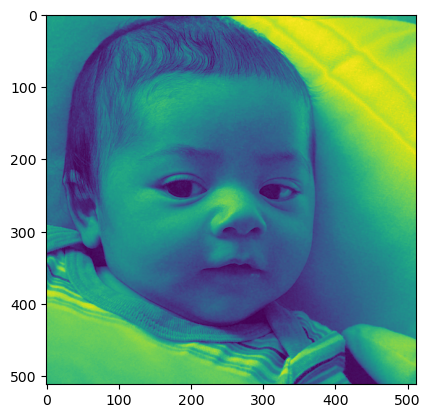

In [14]:
plt.imshow(data.transpose(2, 0, 1)[2,:,:])

In [15]:
data = data.transpose(2, 0, 1)

In [16]:
data.shape

(3, 512, 512)

In [17]:
import os
os.chdir('/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/GAP/gap')
from BinomDataset_ffhq import BinomDataset

In [18]:
minPSNR = -40
maxPSNR = +30
windowSize = (256, 256)

dataset = BinomDataset(data = data[None], windowSize= windowSize, minPSNR= minPSNR, maxPSNR= maxPSNR)
dataloader = dt.DataLoader(dataset, batch_size = 10, shuffle = False)

In [19]:
img = next(iter(dataloader))

In [20]:
img.shape

torch.Size([1, 6, 256, 256])

In [88]:
from torchvision import transforms
crop = transforms.RandomCrop(windowSize)
flipH = transforms.RandomHorizontalFlip()
flipV = transforms.RandomVerticalFlip()

In [89]:
maxProb = 0.99
data = torch.from_numpy(data[None].astype(np.int32))
idx_ = np.random.randint(data.shape[0])
img = crop(data[idx_])

In [90]:
uniform = np.random.rand()*(maxPSNR-minPSNR)+minPSNR

level = (10**(uniform/10.0))/ (img.type(torch.float).mean().item()+1e-5)
level = min(level, maxProb)



In [92]:
img.shape

torch.Size([3, 256, 256])

In [93]:
binom = torch.distributions.binomial.Binomial(total_count=img, probs=torch.tensor([level]))
imgNoise = binom.sample()

In [94]:
imgNoise.shape

torch.Size([3, 256, 256])

In [95]:
img = (img - imgNoise).type(torch.float)
img = img / (img.mean()+1e-8)

imgNoise = imgNoise.type(torch.float)

In [96]:
img.shape, imgNoise.shape

(torch.Size([3, 256, 256]), torch.Size([3, 256, 256]))

In [97]:
out = torch.cat((img, imgNoise),dim = 0)
out.shape

torch.Size([6, 256, 256])

In [98]:
dataset[0].shape

torch.Size([2, 256, 256])

In [14]:
from torchvision.datasets import ImageFolder
import numpy as np
ffhq_path = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/ffhq/'
dataloader = ImageFolder(ffhq_path, target_transform= lambda x : np.array(x))

In [5]:
from typing import Any, Tuple


class BinomImageFolder(ImageFolder):
    def __getitem__(self, index: int) -> Any:
        self =  super().__getitem__(self)
        return self

In [20]:
type(dataloader[0][0]), np.array(dataloader[0][0]).shape

(PIL.Image.Image, (512, 512, 3))

In [1]:
import os
os.chdir('/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/GAP/gap')
from BinomDataset_ffhq import BinomDataset
import matplotlib.pyplot as plt
import numpy as np

In [22]:
ffhq_path = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/ffhq/'
minpsnr = -40
maxpsnr = 40
dataset = BinomDataset(ffhq_path, windowSize = 256, minPSNR = minpsnr, maxPSNR= maxpsnr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  
Max : 2.1036081314086914
Min : 0.0
Mean : 1.0000001192092896
Sum : 196608.015625
  
Max : 1.0
Min : 0.0
Mean : 0.0006968180532567203
Sum : 137.0


(None, None)

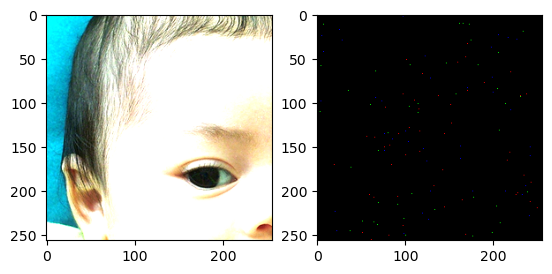

In [97]:
channels = 3
img = dataset[0]
plt.subplot(1, 2, 1)
plt.imshow(img[:channels].permute(1, 2, 0), vmin = 0, vmax = 255)
plt.subplot(1, 2, 2)
plt.imshow(img[channels:].permute(1, 2, 0)/img[channels:].permute(1, 2, 0).mean(), vmin = 0, vmax = 255)
stats(img[:channels].permute(1, 2, 0)), stats(img[channels:].permute(1, 2, 0)), 

In [2]:
def stats(img):
    print(f'''  
min : {img.min()}
max : {img.max()}
mean : {img.mean()}
sum : {img.sum()}''')

In [7]:
from BinomDataset_ffhq_inpaint import BinomDataset
ffhq_path = '/mnt/c/Users/ankit/Desktop/Msc AIML/Data/ffhq/'
minpsnr = -40
maxpsnr = 32
dataset = BinomDataset(ffhq_path, windowSize = 256, minPSNR = minpsnr, maxPSNR= maxpsnr, virtSize= 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  
min : 0.15004576742649078
max : 1.7401481866836548
mean : 1.0000001192092896
sum : 196608.015625
  
min : 0.0
max : 59.0
mean : 19.326269149780273
sum : 3799699.0


(None, None)

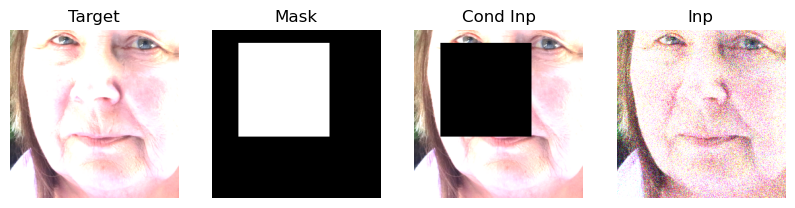

In [4]:
channels = 3
img = dataset[5000000000]
plt.figure(figsize= (10, 10))
plt.subplot(1, 4, 1)
plt.imshow(img[:channels].permute(1, 2, 0), vmin = 0, vmax = 255)
plt.title('Target')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(img[channels:channels + 1].permute(1, 2, 0), vmin = 0, vmax = 1, cmap= 'gray')
plt.title('Mask')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(img[channels + 1:channels  + 1 + 3].permute(1, 2, 0), vmin = 0, vmax = 255)
plt.title('Cond Inp')
plt.axis('off')
plt.subplot(1, 4, 4)
# plt.imshow(img[channels  + 1 + 3:channels  + 1 + 3 + 3].permute(1, 2, 0))
plt.imshow(img[channels  + 1 + 3:channels  + 1 + 3 + 3].permute(1, 2, 0)/img[channels  + 1 + 3:channels  + 1 + 3 + 3].permute(1, 2, 0).mean(), vmin = 0, vmax = 255)
plt.title('Inp')
plt.axis('off')
stats(img[:channels].permute(1, 2, 0)), stats(img[channels  + 1 + 3:channels  + 1 + 3 + 3].permute(1, 2, 0)), 

In [31]:
dataset[900000000]

tensor([[[0.4048, 0.3947, 0.3846,  ..., 1.2752, 1.2448, 1.2347],
         [0.4048, 0.4048, 0.4048,  ..., 1.2549, 1.2549, 1.2549],
         [0.3947, 0.3745, 0.3947,  ..., 1.2549, 1.2752, 1.2650],
         ...,
         [0.3947, 0.4554, 0.4655,  ..., 1.3055, 1.2347, 0.9108],
         [0.3238, 0.4149, 0.4149,  ..., 1.3055, 1.1638, 0.7894],
         [0.2530, 0.3441, 0.4352,  ..., 1.2752, 1.0728, 0.6578]],

        [[1.0120, 1.0019, 0.9918,  ..., 0.7995, 0.7691, 0.7590],
         [1.0120, 1.0120, 1.0120,  ..., 0.7793, 0.7793, 0.7793],
         [1.0019, 0.9918, 1.0019,  ..., 0.7793, 0.7995, 0.7793],
         ...,
         [0.2631, 0.2935, 0.3036,  ..., 1.2347, 1.1740, 0.8501],
         [0.2125, 0.2631, 0.2328,  ..., 1.2549, 1.1031, 0.7185],
         [0.1619, 0.2024, 0.2631,  ..., 1.2549, 1.0424, 0.6072]],

        [[0.4858, 0.4858, 0.4757,  ..., 0.6376, 0.6072, 0.5971],
         [0.4959, 0.4959, 0.4858,  ..., 0.6173, 0.6173, 0.6173],
         [0.4959, 0.4757, 0.4757,  ..., 0.6173, 0.6376, 0.

In [5]:
from GAP_UNET_ResBlock_ffhq import UN
model = UN(channels = 3, levels=10, depth=6,
                 start_filts=28, up_mode = 'transpose')
model(img[channels:][None])

/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/GAP/gap/GAP_UNET_ResBlock_ffhq.py:255: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
/mnt/c/Users/ankit/Desktop/Msc AIML/msc-project/GAP/gap/GAP_UNET_ResBlock_ffhq.py:256: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


tensor([[[[ 0.0675,  0.0882,  0.1085,  ...,  0.1084,  0.0347,  0.2330],
          [-0.0016,  0.2757,  0.3726,  ...,  0.1130,  0.2050,  0.1051],
          [ 0.0575,  0.2703,  0.1375,  ...,  0.2738,  0.5525,  0.2278],
          ...,
          [ 0.0167,  0.1201,  0.2739,  ...,  0.3492, -0.0112,  0.1442],
          [-0.1039, -0.0399, -0.0157,  ...,  0.0812,  0.5429,  0.0204],
          [-0.1029,  0.0886, -0.0786,  ...,  0.0153, -0.1120,  0.0137]],

         [[ 0.0053,  0.2188,  0.3096,  ..., -0.0863,  0.0060, -0.0559],
          [-0.1596, -0.0575,  0.0509,  ...,  0.1978,  0.1910,  0.1987],
          [ 0.0753,  0.1133, -0.1335,  ...,  0.1662,  0.1409,  0.0894],
          ...,
          [-0.1949,  0.0961, -0.0564,  ...,  0.0090,  0.2755,  0.3274],
          [ 0.0126,  0.1061,  0.1112,  ..., -0.1090,  0.2081,  0.0047],
          [-0.0849, -0.0392, -0.0133,  ...,  0.0723,  0.1170,  0.1779]],

         [[-0.0892,  0.1759,  0.1424,  ...,  0.1998, -0.1156,  0.3296],
          [ 0.1368,  0.1942,  

In [51]:
img[channels:][None].shape, img[None].shape

(torch.Size([1, 7, 256, 256]), torch.Size([1, 10, 256, 256]))

In [6]:
model(img[channels:][None]).shape

torch.Size([1, 3, 256, 256])